# Exploratory Data Analysis

Understanding our data is a crucial step in any data science project. In this assignment, you will perform an exploratory data analysis of corpus of documents. The corpus consists of 11,587 documents, each of which is a news article. The documents are stored in a folder called `data` in the root of the repository and the data is stored in the shared google drive `datasets`.

In this assignment, you will analyze a corpus of news documents to answer the following questions:

0. What is the nature of our data?
    - 0a. What is the size of the corpus?
    - 0b. Are there any duplicates in the corpus? If so, drop them.
    - 0c. Are there any missing values in the corpus?
    - 0d. How many unique documents are there in the corpus?
1. What is the distribution of `token`s per document?
    - 1a. What is the longest article?
    - 1b. What is the shortest article?
    - 1c. What is the 95th percentile of article lengths?
2. How many different sources are there in the corpus?
    - 2a. How many different sources are there in the dataset?
    - 2b. What is the distribution of articles per source?

In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas()

## News Corpus

You are provided the following news corpus: `data/news_corpus.csv`. The corpus contains the following columns:

- `index` int: The unique identifier of the document.
- `source` str: The source of the document
- `title` str: The title of the document
- `text` str: The content of the article

The data used in this notebook comes from the [`StoryGraph`](https://archive.org/details/storygraph?tab=about) project, created and maintained by Prof. Alexander Nwala.

```BibTeX
@MISC {nwala-cj20,
    author = {Alexander Nwala and Michele C. Weigle and Michael L. Nelson},
     title = {365 Dots in 2019: Quantifying Attention of News Sources},
     year = {2020},
      month = may,
     howpublished = {Poster/demo accepted at the Computation + Journalism Symposium (symposium cancelled due to COVID-19)},
     arxiv = {https://arxiv.org/abs/2003.09989},
     pubdate = {202005}
}
```

## Load Data into Pandas dataframe

In [3]:
df = pd.read_csv('news-2023-02-01.csv')
df.head()

,source,title,text
0,politicususa,Prosecutors Pay Attention: Stormy Daniels Than...,Manhattan prosecutors are likely to notice tha...
1,politicususa,Investigators Push For Access To Trump Staff C...,Print\nInvestigators looking into Donald Trump...
2,politicususa,The End Is Near For George Santos As He Steps ...,The AP reported:\nRepublican Rep. George Santo...
3,politicususa,Rachel Maddow Cuts Trump To The Bone With Stor...,Rachel Maddow showed how Trump committed a cri...
4,vox,Alec Baldwin has been formally charged with in...,Candles are placed in front of a photo of cine...


## 0. What is the nature of our data?

Using your coding skills, answer the following questions. Please comment on your code and results.

In [4]:
## 0a. What is the size of the corpus?

### YOUR CODE HERE
len(df)

11587

there are 11587 observations in the dataset

In [6]:
## 0b. Are there any duplicates in the corpus? If so, remove or drop them.
#the fun way
df2 = df[~np.array(df.duplicated(subset = 'text',keep='first'))]
print(df2.shape)
#the less fun way
df3 = df.drop_duplicates(subset='text')
df3.shape
## YOUR CODE HERE

(1063, 3)


(1063, 3)

It looks like only 1063 entries are not duplicated based off the text. Note that we do this off the text only. If we didn't then the title being different, but having the same text as another document would not be removed. This doesn't warrant a new body of text as the text is already in the df elsewhere.

In [7]:
## 0c. Are there any missing values in the corpus? If so, what data are missing?
## Should the missing values be removed, explain?

## YOUR CODE HERE
print('there is ' + str(df2.isnull().values.sum()) + ' missing value in the dataframe')
df2.iloc[np.where(df2.isnull().values == True)[0][0]]#find where the null values are then double index to get the row value out of the array inside a tuple, and index the dataframe at that row

there is 1 missing value in the dataframe


source                                    realclearpolitics
title     Trump Struggled With Identity at His First Pub...
text                                                    NaN
Name: 40, dtype: object

It looks like we should definitely remove this as the text is missing which is the important feature we are going to look at for this NLP model

In [8]:
df2.drop(index = 40, inplace = True)

/tmp/ipykernel_64/3892136238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(index = 40, inplace = True)


In [9]:
df2.reset_index(drop = True, inplace = True)
df2['text'][40] #it's gone all good

'The Joe and Hunter Biden Scandal Convergence\nByron York , Washington Examiner January 31, 2023\n'

## 1.0 What is the distribution of `token`s per document?

Use the `spaCy` library to tokenize the text and analyze the distribution of token frequencies. You can use the `Counter` class from the `collections` library to count the number of times each token appears in the corpus.

In [10]:
#!pip install spacy
#!python -m spacy download en

  Using cached spacy-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
  Using cached pathy-0.10.1-py3-none-any.whl (48 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached murmurhash-1.0.9-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (21 kB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
  Using cached wasabi-1.1.1-py3-none-any.whl (27 kB)
  Using cached srsly-2.4.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (492 kB)
  Using cached preshed-3.0.8-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (124 kB)
  Using cached pydantic-1.10.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached spacy_loggers-1.0.4-py3-none-any.whl (11 kB)
  Using cached cymem-2.0.7-cp310-cp310-man

In [11]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Load the spacy model: nlp
NLP = spacy.load('en_core_web_sm')


In [12]:
## Generate the tokens using Spacy

## YOUR CODE HERE
docs = [NLP(df2['text'][i]) for i in range(len(df2))]

In [27]:
## Count the tokens

## YOUR CODE HERE
ls = []
for i in range(len(docs)):
    ls += [str(token) for token in docs[i]] #make a big list of all tokens(convert to words so counter recognizes it)
token_counts = Counter(ls)#count 
print('the number of total tokens in the corpus is ' + str(sum(dict(token_counts).values()))) #sum of all the tokens
print('the number of unique tokens in the corpus is ' + str(len(dict(token_counts).keys()))) #count the keys which are tokens

the number of total tokens in the corpus is 921219
the number of unique tokens in the corpus is 25347


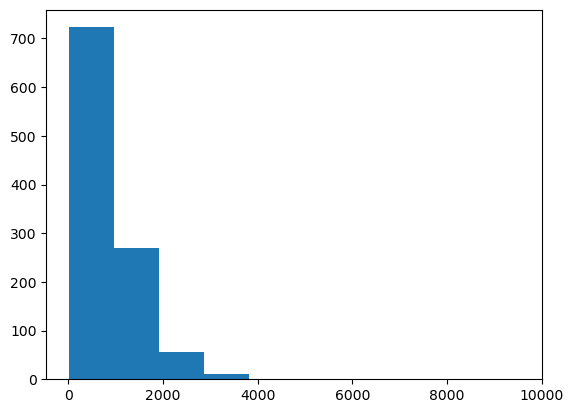

In [28]:
## YOUR CODE HERE
## Plot the distribution of the number of tokens per document

counts = [len(docs[i]) for i in range(len(docs))]
plt.hist(counts,bins = 10)
plt.show()

as seen in the next block, there is an outlier which is making this visualization hard to see. Log scale won't work as the skew is happening in the same digits place.

In [29]:
## 1a. What is the longest article?

## YOUR CODE HERE
max(counts)

9533

In [30]:
## 1b. What is the shortest article?

## YOUR CODE HERE
min(counts)

16

In [31]:
## 1c. What is the 95th percentile of the number of tokens per document?
## Hint: use np.percentile

## YOUR CODE HERE
np.percentile(counts,95)

2003.9499999999998

In [35]:
## 1d. What is the size of the vocabulary and the frequencies of each token in the corpus?

import string
from collections import Counter

## Create list of stopwords from spacy
stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation)

## YOUR CODE HERE
## hint: use Counter
corpus_frequencies = {}
for key in token_counts:
    if key in stop_words: #can't remove from a dictionary you are iterating through
        continue
    else:
        corpus_frequencies[key]=token_counts[key] #so add the non stop words to a new dictionary

In [36]:
len(corpus_frequencies)
#corpus_frequencies

25018

## 2.0 How many different sources are there in the corpus?

Please describe how many different sources exist in the dataset.

In [37]:
## 2a. Plot how many different sources are there in the corpus?

## YOUR CODE HERE
sources = df2['source'].unique()
len(sources)

20

In [40]:
articlesPerSource = []
for i in sources:
    articlesPerSource.append(len(df2[df2['source'] == i])) #count the number of articles each source has
articlesPerSource

[13, 21, 54, 30, 72, 61, 78, 44, 43, 217, 17, 1, 3, 53, 212, 43, 85, 12, 2, 1]

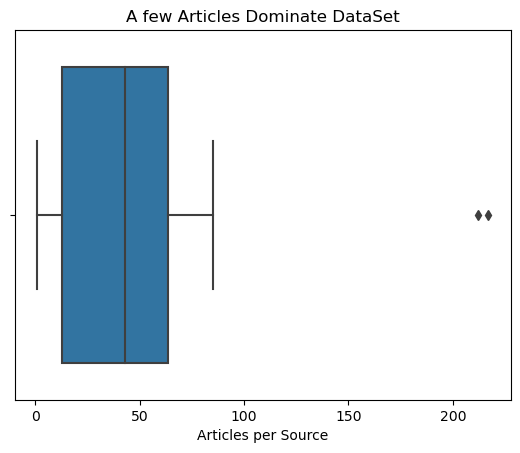

In [42]:
## 2b. Plot the distribution of articles per source?
## hint: use seaborn boxplot
import seaborn as sns
## YOUR CODE HERE
ax = sns.boxplot(x = articlesPerSource)
ax.set(xlabel = 'Articles per Source', title = 'A few Articles Dominate DataSet')
plt.show()